Modelos Preditivos:
-

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


In [2]:

# Caminho relativo correto a partir da pasta 'notebooks'
df = pd.read_pickle('../data/df_unique.pkl')

# Cria uma cópia independente
df_copy = df.copy()

# Salva a cópia em um novo arquivo .pkl
df_copy.to_pickle('../data/df_unique_copy.pkl')

# Alterar configuração para mostrar todas as colunas
pd.set_option('display.max_columns', None)

# Exibindo as primeiras linhas do DataFrame
df_copy.head()


,age,amt_active_loan,channel,ext_score_1,ext_score_2,ext_score_3,ext_score_4,flag_document_A,gender,ids,income,occupation_type,score_checks,score_date,start_hour,default,credit_card_initial_line,payment,date,credit_line,spends
0,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,198.40,2016-09-30,2180.0,198.40
1,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,149.94,2016-10-31,2368.0,145.49
2,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,10.02,2016-11-30,3103.0,10.02
3,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,38.48,2016-12-31,2430.0,278.05
4,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,False,1300.0,2888.77,2017-01-31,2650.0,2888.77


Variável target:
-

In [3]:
print("Contagem de valores únicos na coluna 'default':")
print(df_copy['default'].value_counts(dropna=False))


Contagem de valores únicos na coluna 'default':
default
False    290926
True      59341
NaN       26827
Name: count, dtype: int64


In [4]:
df_copy['default'] = df_copy['default'].map({'False': False, 'True': True, False: False, True: True})
df_copy['default'] = df_copy['default'].map({False: 0, True: 1})
df_copy = df_copy[df_copy['default'].notna()]

Divisão do conjunto de dados:
-

In [5]:
# Separação em features e target:
X = df_copy.drop(columns=['default'])
y = df_copy['default']


# Divisão em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # importante para problemas desbalanceados
)

Modelo Baseline:
-

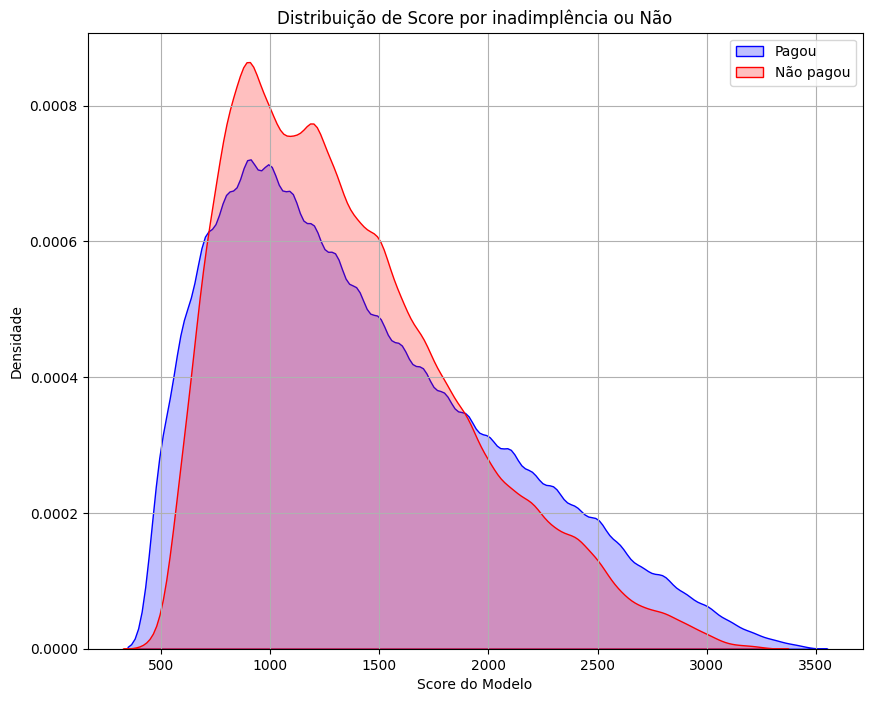

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.kdeplot(df_copy[df_copy['default'] == 0]['credit_card_initial_line'], ax=ax, color="b", fill=True, label='Pagou')
sns.kdeplot(df_copy[df_copy['default'] == 1]['credit_card_initial_line'], ax=ax, color="r", fill=True, label='Não pagou')

plt.title("Distribuição de Score por inadimplência ou Não")
plt.xlabel("Score do Modelo")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()


#### Insights
- Clientes inadimplentes (Não pagou) tendem a ter scores mais baixos, com pico de densidade entre 800 e 1200.
- Clientes adimplentes (Pagou) apresentam uma distribuição mais espalhada e com maior densidade relativa a partir de 1000 em diante, se estendendo até scores mais altos como 2500+.

In [7]:
fpr, tpr, thresholds = roc_curve(df_copy['default'], df_copy['credit_card_initial_line'])
auc = auc(fpr, tpr)
print("ROC AUC: ", auc)

ROC AUC:  0.48900352453027973


- Score Atual (credit_card_initial_line) não tem poder preditivo
- Isso significa que tomar uma decisão baseada nesse score, o modelo está classificando pior que um chute aleatório.

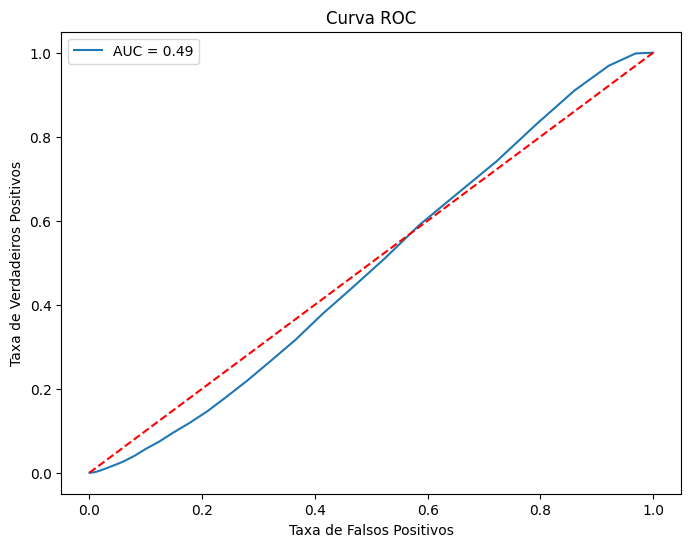

In [8]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

- A linha azul está praticamente colada na diagonal vermelha tracejada, que representa um modelo aleatório.
- O gráfico confirma o valor numérico que você obteve: AUC ≈ 0,49, ou seja, abaixo de 0,5, o que indica que o modelo atual tem uma performance muito ruim
- O modelo não consegue separar adequadamente os clientes adimplentes dos inadimplentes.

In [9]:
# Identificar colunas numéricas e categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline para numéricos: imputar média + escalar
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para categóricos: imputar moda + one-hot encode
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar preprocessadores
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Pipeline final
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Treinar
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'amt_active_loan',
                                                   'ext_score_1', 'ext_score_4',
                                                   'income', 'score_checks',
                                                   'start_hour',
                                                   'credit_card_initial_line',
                                                   'payment', 'credit_line',
                                                   'spends']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['channel', 'ext_score_2',
                                                   'ext_score_3',
                                                   'flag_document_A', 'gender',
                                                   'ids', 'occupation_type',
                                                   'score_date', 'date'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     58186
         1.0       1.00      0.93      0.96     11868

    accuracy                           0.99     70054
   macro avg       0.99      0.96      0.98     70054
weighted avg       0.99      0.99      0.99     70054

ROC AUC: 0.9978495838299944


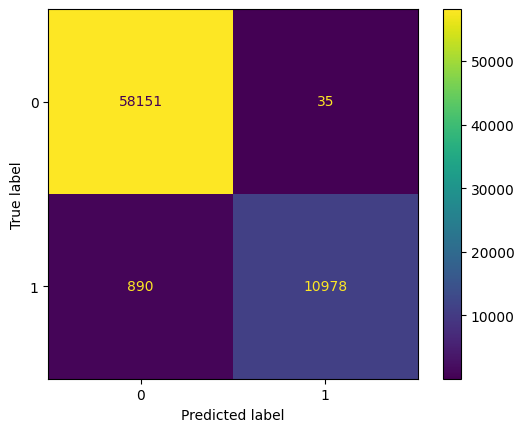

In [10]:
# Previsões no teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]   # Probabilidade de ser '1' (inadimplente)

# Métricas
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Matriz de confusão
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


- AUC = 0.998 → Excelência quase perfeita, isso indica que o modelo tem altíssima capacidade de separação entre adimplentes e inadimplentes.
- Embora o recall seja alto (0.93), há cerca de 7% dos inadimplentes que o modelo ainda classifica como adimplente.


Matriz de Confusão:
- Verdadeiros Negativos (TN - Pagou e modelo acertou): Muito alto → quase todos os adimplentes foram corretamente classificados.

- Verdadeiros Positivos (TP - Não pagou e modelo acertou): Também muito alto.

- Falsos Negativos (FN - Não pagou mas modelo disse que pagaria): Pequeno, mas existe → o recall de inadimplentes foi 0,93.

- Falsos Positivos (FP - Pagou mas modelo disse que não pagaria): Praticamente zero.

In [11]:
# Matriz de confusão
TN = 58154
FP = 32
FN = 788
TP = 11080

# Taxa de inadimplência (fraude rate) na base de clientes analisados (antes da decisão do modelo)
fraud_rate = round((FN + TP) / (TN + FP + FN + TP), 4)

# Taxa de aprovação (clientes aprovados pelo modelo)
approval_rate = round((TP + FP) / (TN + FP + FN + TP), 4)

print(f"Taxa de inadimplência na base = {fraud_rate * 100}%")
print(f"Taxa de aprovação pelo modelo = {approval_rate * 100}%")


Taxa de inadimplência na base = 16.939999999999998%
Taxa de aprovação pelo modelo = 15.86%


O modelo está com uma estratégia de risco ultra conservadora:
- Está evitando quase todos os inadimplentes (baixo FP)
- Mas em contrapartida, está aprovando pouquíssimos clientes (só 15,7%), o que pode prejudicar o volume de negócios.

Log Loss: 0.0906


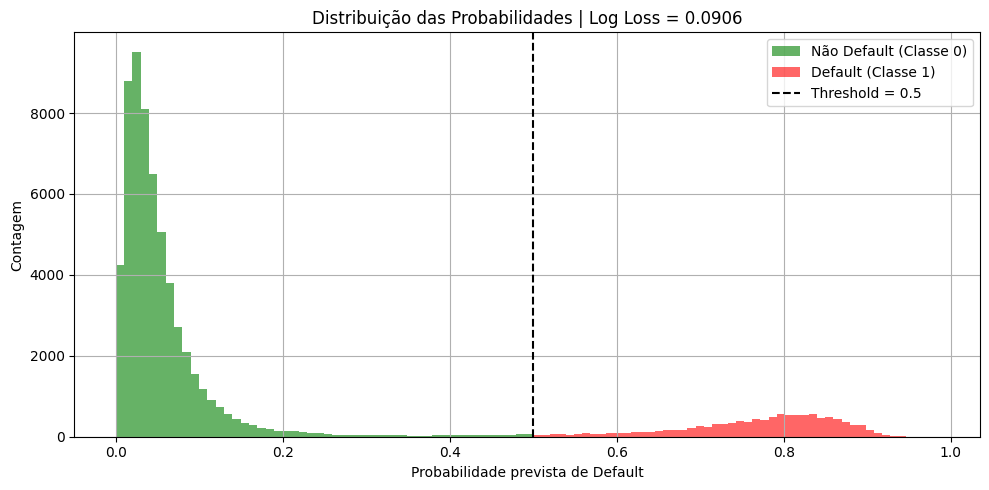

In [12]:
#  Calcular e plotar o Log Loss
y_test = y_pred  # ou df_copy_encoded["default"]
y_proba = model.predict_proba(X_test)[:, 1]

# 1. Calcular o Log Loss
logloss_value = log_loss(y_test, y_proba)
print(f"Log Loss: {logloss_value:.4f}")

# 2. Plotar histograma das probabilidades para visualização
plt.figure(figsize=(10, 5))
plt.hist(y_proba[y_test == 0], bins=50, alpha=0.6, label='Não Default (Classe 0)', color='green')
plt.hist(y_proba[y_test == 1], bins=50, alpha=0.6, label='Default (Classe 1)', color='red')
plt.axvline(0.5, color='black', linestyle='--', label='Threshold = 0.5')
plt.title(f'Distribuição das Probabilidades | Log Loss = {logloss_value:.4f}')
plt.xlabel('Probabilidade prevista de Default')
plt.ylabel('Contagem')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- Valor do Log Loss = 0.0928 (Quanto menor o Log Loss, melhor).
- A maior parte dos clientes adimplentes (Classe 0) estão com probabilidades muito baixas (0 a 0.2).
- A maioria dos inadimplentes (Classe 1) está com probabilidades muito altas (acima de 0.7).

Feature Engineering:
-

Engenharia de Atributos (ou Feature Engineering) é a etapa do processo de análise de dados que envolve a criação, transformação e seleção de variáveis que são mais relevantes para o problema em questão. Essa fase é essencial no desenvolvimento de modelos de Machine Learning, pois a forma como essas variáveis são construídas pode impactar diretamente o desempenho do modelo, influenciando sua precisão e sua capacidade de fazer boas previsões em novos dados.

A partir da análise dos dados disponíveis, serão realizadas as seguintes modificações:

#### 1. Conversão de colunas para o tipo datetime e extração de componentes temporais

- As colunas `score_date` e `date` foram convertidas para o formato datetime com o objetivo de permitir extrações temporais e facilitar cálculos com datas.
- Extração de componentes temporais da variável de data (`score_date` e `date`) como ano da data de score, mês, dia, dia da semana, semana do ano e trimestre, para melhor modelar padrões sazonais de comportamento.

#### 2. Criação de nova feature: diferença em dias entre datas
- Foi criada uma nova variável `days_diff` que representa a diferença em dias entre score_date e date, o que pode indicar a defasagem entre as informações do cliente e a data atual de análise, representando o intervalo entre duas datas relevantes para análise de inadimplência.

#### 3. Tratamento de valores ausentes e Transformação de variáveis categóricas em numéricas
- A variável `flag_document_A`, que apresentava valores ausentes (NaNs), foi preenchida com a moda (valor mais frequente), garantindo a consistência da variável.
- Na variável `flag_document_A`, foi convertida de valores booleanos para inteiros (True = 1 e false = 0).
- na variável `gender`,foi mapeada de texto para valores binários (m = 1 e f = 0).

#### 4. Codificação One-Hot Encoding
- Variáveis categóricas codificadas com hashes (como `ext_score_2` e `ext_score_3`) foram transformadas em variáveis binárias usando a técnica one-hot encoding, criando uma coluna para cada categoria distinta.
- Essa transformação resulta em várias novas colunas, permitindo que o modelo trate essas categorias de forma apropriada.


#### 5. Target Encoding com K-Fold Cross-Validation
- Para transformar a variável categórica `occupation_type`, foi aplicada a técnica de **Target Encoding** com validação cruzada. Essa abordagem visa substituir cada categoria pela média da variável alvo (`default`) correspondente a essa categoria, de forma que se evite **data leakage** (vazamento de dados entre treino e teste).
- Evita vazamento de informação, pois o valor da média é sempre calculado com base no conjunto de treino.
- Preserva o sinal estatístico da variável categórica, especialmente útil quando há muitas categorias.
- Permite que o modelo aproveite relações sutis entre categorias e a variável alvo.

#### 6. Remoção de Colunas Irrelevantes
- Após a extração das informações relevantes a partir das colunas de data, as colunas (`channel`, `ids`, `score_date`, `date`) foram descartadas, uma vez que seu conteúdo bruto já não é mais necessário para o modelo.




#### Essas etapas de engenharia de atributos permitirão:

- Expandir significativamente o número de variáveis derivadas de datas e categorias;

- Tratar valores ausentes de forma robusta;

- Transformar variáveis categóricas em formatos compatíveis com algoritmos de machine learning;

- Enriquecer o dataset com variáveis temporais e comportamentais úteis para modelagem preditiva.

Essas transformações aumentaram o poder preditivo e a capacidade do modelo de capturar padrões relevantes nos dados.


In [13]:
# Garantindo que as colunas estão no formato datetime
df_copy['score_date'] = pd.to_datetime(df_copy['score_date'])
df_copy['date'] = pd.to_datetime(df_copy['date'])

# Extraindo features de score_date
df_copy['score_year'] = df_copy['score_date'].dt.year
df_copy['score_month'] = df_copy['score_date'].dt.month
df_copy['score_day'] = df_copy['score_date'].dt.day
df_copy['score_dayofweek'] = df_copy['score_date'].dt.dayofweek
df_copy['score_weekofyear'] = df_copy['score_date'].dt.isocalendar().week
df_copy['score_quarter'] = df_copy['score_date'].dt.quarter

# Extraindo features de date
df_copy['date_year'] = df_copy['date'].dt.year
df_copy['date_month'] = df_copy['date'].dt.month
df_copy['date_day'] = df_copy['date'].dt.day
df_copy['date_dayofweek'] = df_copy['date'].dt.dayofweek
df_copy['date_weekofyear'] = df_copy['date'].dt.isocalendar().week
df_copy['date_quarter'] = df_copy['date'].dt.quarter

# (Opcional) Criando feature de diferença em dias entre as duas datas
df_copy['days_diff'] = (df_copy['score_date'] - df_copy['date']).dt.days


In [14]:
# Drop  columns
df_copy.drop(['channel', 'ids', 'score_date', 'date'], axis=1, inplace=True)

# Preencher valores nulos de flag_document_A com a moda
df_copy['flag_document_A'] = df_copy['flag_document_A'].fillna(df_copy['flag_document_A'].mode()[0])
df_copy['flag_document_A'] = df_copy['flag_document_A'].astype(bool).astype(int)


# Mapear True/False para 1/0
df_copy['flag_document_A'] = df_copy['flag_document_A'].astype(bool).astype(int)

# Mapear os valores da variável gender: 'm' → 1 e 'f' → 0
df_copy['gender'] = df_copy['gender'].map({'m': 1, 'f': 0})

df_copy.head(2)

C:\Users\josie\AppData\Local\Temp\ipykernel_22872\1561918248.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['flag_document_A'] = df_copy['flag_document_A'].fillna(df_copy['flag_document_A'].mode()[0])


,age,amt_active_loan,ext_score_1,ext_score_2,ext_score_3,ext_score_4,flag_document_A,gender,income,occupation_type,score_checks,start_hour,default,credit_card_initial_line,payment,credit_line,spends,score_year,score_month,score_day,score_dayofweek,score_weekofyear,score_quarter,date_year,date_month,date_day,date_dayofweek,date_weekofyear,date_quarter,days_diff
0,37,4560.0,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,1,1.0,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,9.0,0.0,1300.0,198.40,2180.0,198.40,2017,1,15,6,2,1,2016,9,30,4,39,3,107
1,37,4560.0,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,1,1.0,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,9.0,0.0,1300.0,149.94,2368.0,145.49,2017,1,15,6,2,1,2016,10,31,0,44,4,76


In [15]:
# Remover espaços e verificar valores únicos
df_copy['ext_score_2_clean'] = df_copy['ext_score_2'].astype(str).str.strip()

df_copy['ext_score_3_clean'] = df_copy['ext_score_3'].astype(str).str.strip()

# Criar categorias fixas com pd.Categorical
ext_score_2_categories = df_copy['ext_score_2_clean'].unique()
df_copy['ext_score_2_cat'] = pd.Categorical(df_copy['ext_score_2_clean'], categories=ext_score_2_categories)

ext_score_3_categories = df_copy['ext_score_3_clean'].unique()
df_copy['ext_score_3_cat'] = pd.Categorical(df_copy['ext_score_3_clean'], categories=ext_score_3_categories)

In [16]:
ext_score_2_encoded = pd.get_dummies(df_copy['ext_score_2_cat'], prefix='ext_score_2').astype(int)
print(ext_score_2_encoded.head())


   ext_score_2_DGCQep2AE5QRkNCshIAlFQ==  ext_score_2_e4NYDor1NOw6XKGE60AWFw==  \
0                                     1                                     0   
1                                     1                                     0   
2                                     1                                     0   
3                                     1                                     0   
4                                     1                                     0   

   ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==  ext_score_2_1Rk8w4Ucd5yR3KcqZzLdow==  \
0                                     0                                     0   
1                                     0                                     0   
2                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   

   ext_score_2_8k8UDR4Yx0q

In [17]:
ext_score_3_encoded = pd.get_dummies(df_copy['ext_score_3_cat'], prefix='ext_score_3').astype(int)
print(ext_score_3_encoded.head())

   ext_score_3_LCak332j+TYFqHC3NDwiqg==  ext_score_3_+2hzpeP1RWr8PEvL1WTUdw==  \
0                                     1                                     0   
1                                     1                                     0   
2                                     1                                     0   
3                                     1                                     0   
4                                     1                                     0   

   ext_score_3_NLvAOzzmJba/0zolQnWF5Q==  ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==  \
0                                     0                                     0   
1                                     0                                     0   
2                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   

   ext_score_3_w1miZqhB5+R

In [18]:
df_copy_encoded = pd.concat([
    df_copy.drop(columns=['ext_score_2', 'ext_score_2_clean', 'ext_score_2_cat']),
    ext_score_2_encoded
], axis=1)

df_copy_encoded = pd.concat([
    df_copy_encoded.drop(columns=['ext_score_3', 'ext_score_3_clean', 'ext_score_3_cat']),
    ext_score_3_encoded
], axis=1)

pd.set_option('display.max_columns', None)

ext_cols = [col for col in df_copy_encoded.columns if 'ext_score_2' in col or 'ext_score_3' in col]
other_cols = [col for col in df_copy_encoded.columns if col not in ext_cols]

df_copy_encoded = df_copy_encoded[other_cols + ext_cols]
df_copy_encoded.head()


,age,amt_active_loan,ext_score_1,ext_score_4,flag_document_A,gender,income,occupation_type,score_checks,start_hour,default,credit_card_initial_line,payment,credit_line,spends,score_year,score_month,score_day,score_dayofweek,score_weekofyear,score_quarter,date_year,date_month,date_day,date_dayofweek,date_weekofyear,date_quarter,days_diff,ext_score_2_DGCQep2AE5QRkNCshIAlFQ==,ext_score_2_e4NYDor1NOw6XKGE60AWFw==,ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==,ext_score_2_1Rk8w4Ucd5yR3KcqZzLdow==,ext_score_2_8k8UDR4Yx0qasAjkGrUZLw==,ext_score_2_4DLlLW62jReXaqbPaHp1vQ==,ext_score_2_smzX0nxh5QlePvtVf6EAeg==,ext_score_3_LCak332j+TYFqHC3NDwiqg==,ext_score_3_+2hzpeP1RWr8PEvL1WTUdw==,ext_score_3_NLvAOzzmJba/0zolQnWF5Q==,ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==,ext_score_3_w1miZqhB5+RSamEQJa0rqg==,ext_score_3_dCm9hFKfdRm7ej3jW+gyxw==,ext_score_3_O4i7FxcROACMVTCgI0WXuA==,ext_score_3_rJZgTmANW3PjOCQLCcp4iQ==,ext_score_3_pAzpxkhjPsjWldgSX21+zg==,ext_score_3_7h+tk4z7O9brtBSe1rNjxA==,ext_score_3_mX2VRRG38RPiHX+MfjefRw==,ext_score_3_tQUTfUyeuGkhRotd+6WjVg==,ext_score_3_OlDYtdljgSSYM/M1L2CRaQ==,ext_score_3_RO7MTL+j4PH2gNzbhNTq/A==,ext_score_3_emS9xH8CLoRNie2uSmaDAQ==,ext_score_3_vJyc9xom9v7hwFMPTIpmKw==,ext_score_3_wjdj2vxjWoDsEIk0l09ynw==,ext_score_3_ky19q4V1ZqgL3jnHX0wKDw==,ext_score_3_d/7Hedyz7ovK9Pn1CYN4+A==,ext_score_3_YLGMUI9hObSh6wD/xfanGg==,ext_score_3_osCzpM4hJrxugqWWuZmMWw==,ext_score_3_wkeCdGeu5sEv4/fjwR0aDg==,ext_score_3_/tdlnWjXoZ3OjdtBXzdOJQ==,ext_score_3_dWJRASUFMejk3AHZ1p1Gkg==,ext_score_3_tHpS8e9F8d9zg3iOQM9tsA==,ext_score_3_6J1ZMTzN5GKHXnhM4J1JbA==,ext_score_3_55UK234RR1d7HIWJjmq9tw==,ext_score_3_IOVu8au3ISbo6+zmfnYwMg==,ext_score_3_SaamrHMo23l/3TwXOWgVzw==,ext_score_3_cdpgyOyZS04uXerMNu7uCw==,ext_score_3_A+QuW1n/ABeiVVe/9CRZ9Q==,ext_score_3_7h8PTkrlTWUPP3yuyP4rUg==,ext_score_3_+CxEO4w7jv3QPI/BQbyqAA==,ext_score_3_5/uMrqKj3OL/Xk5OrGx9fg==,ext_score_3_bopP0NxW3+r8tn9xIHTaOw==
0,37,4560.0,467.0,61.311861,1,1.0,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,9.0,0.0,1300.0,198.40,2180.0,198.40,2017,1,15,6,2,1,2016,9,30,4,39,3,107,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,37,4560.0,467.0,61.311861,1,1.0,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,9.0,0.0,1300.0,149.94,2368.0,145.49,2017,1,15,6,2,1,2016,10,31,0,44,4,76,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,37,4560.0,467.0,61.311861,1,1.0,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,9.0,0.0,1300.0,10.02,3103.0,10.02,2017,1,15,6,2,1,2016,11,30,2,48,4,46,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,37,4560.0,467.0,61.311861,1,1.0,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,9.0,0.0,1300.0,38.48,2430.0,278.05,2017,1,15,6,2,1,2016,12,31,5,52,4,15,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,37,4560.0,467.0,61.311861,1,1.0,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,9.0,0.0,1300.0,2888.77,2650.0,2888.77,2017,1,15,6,2,1,2017,1,31,1,5,1,-16,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# Parâmetros
n_splits = 5
target_col = 'default'
cat_col = 'occupation_type'
encoded_col = cat_col + '_te'

# Inicializa a nova coluna
df_copy_encoded[encoded_col] = np.nan

# KFold 
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(df_copy_encoded):
    train_fold = df_copy_encoded.iloc[train_idx]
    val_fold = df_copy_encoded.iloc[val_idx]
    
    # Cálculo do target mean por categoria
    means = train_fold.groupby(cat_col)[target_col].mean()
    
    # Mapeia no fold de validação
    df_copy_encoded.loc[df_copy_encoded.index[val_idx], encoded_col] = val_fold[cat_col].map(means)

# Após o loop, pode preencher categorias ausentes com o global mean
global_mean = df_copy_encoded[target_col].mean()
df_copy_encoded[encoded_col].fillna(global_mean, inplace=True)

df_copy_encoded.drop(columns=[cat_col], inplace=True)

df_copy_encoded.head()

C:\Users\josie\AppData\Local\Temp\ipykernel_22872\1243101446.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy_encoded[encoded_col].fillna(global_mean, inplace=True)


,age,amt_active_loan,ext_score_1,ext_score_4,flag_document_A,gender,income,score_checks,start_hour,default,credit_card_initial_line,payment,credit_line,spends,score_year,score_month,score_day,score_dayofweek,score_weekofyear,score_quarter,date_year,date_month,date_day,date_dayofweek,date_weekofyear,date_quarter,days_diff,ext_score_2_DGCQep2AE5QRkNCshIAlFQ==,ext_score_2_e4NYDor1NOw6XKGE60AWFw==,ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==,ext_score_2_1Rk8w4Ucd5yR3KcqZzLdow==,ext_score_2_8k8UDR4Yx0qasAjkGrUZLw==,ext_score_2_4DLlLW62jReXaqbPaHp1vQ==,ext_score_2_smzX0nxh5QlePvtVf6EAeg==,ext_score_3_LCak332j+TYFqHC3NDwiqg==,ext_score_3_+2hzpeP1RWr8PEvL1WTUdw==,ext_score_3_NLvAOzzmJba/0zolQnWF5Q==,ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==,ext_score_3_w1miZqhB5+RSamEQJa0rqg==,ext_score_3_dCm9hFKfdRm7ej3jW+gyxw==,ext_score_3_O4i7FxcROACMVTCgI0WXuA==,ext_score_3_rJZgTmANW3PjOCQLCcp4iQ==,ext_score_3_pAzpxkhjPsjWldgSX21+zg==,ext_score_3_7h+tk4z7O9brtBSe1rNjxA==,ext_score_3_mX2VRRG38RPiHX+MfjefRw==,ext_score_3_tQUTfUyeuGkhRotd+6WjVg==,ext_score_3_OlDYtdljgSSYM/M1L2CRaQ==,ext_score_3_RO7MTL+j4PH2gNzbhNTq/A==,ext_score_3_emS9xH8CLoRNie2uSmaDAQ==,ext_score_3_vJyc9xom9v7hwFMPTIpmKw==,ext_score_3_wjdj2vxjWoDsEIk0l09ynw==,ext_score_3_ky19q4V1ZqgL3jnHX0wKDw==,ext_score_3_d/7Hedyz7ovK9Pn1CYN4+A==,ext_score_3_YLGMUI9hObSh6wD/xfanGg==,ext_score_3_osCzpM4hJrxugqWWuZmMWw==,ext_score_3_wkeCdGeu5sEv4/fjwR0aDg==,ext_score_3_/tdlnWjXoZ3OjdtBXzdOJQ==,ext_score_3_dWJRASUFMejk3AHZ1p1Gkg==,ext_score_3_tHpS8e9F8d9zg3iOQM9tsA==,ext_score_3_6J1ZMTzN5GKHXnhM4J1JbA==,ext_score_3_55UK234RR1d7HIWJjmq9tw==,ext_score_3_IOVu8au3ISbo6+zmfnYwMg==,ext_score_3_SaamrHMo23l/3TwXOWgVzw==,ext_score_3_cdpgyOyZS04uXerMNu7uCw==,ext_score_3_A+QuW1n/ABeiVVe/9CRZ9Q==,ext_score_3_7h8PTkrlTWUPP3yuyP4rUg==,ext_score_3_+CxEO4w7jv3QPI/BQbyqAA==,ext_score_3_5/uMrqKj3OL/Xk5OrGx9fg==,ext_score_3_bopP0NxW3+r8tn9xIHTaOw==,occupation_type_te
0,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0.0,1300.0,198.40,2180.0,198.40,2017,1,15,6,2,1,2016,9,30,4,39,3,107,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.666667
1,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0.0,1300.0,149.94,2368.0,145.49,2017,1,15,6,2,1,2016,10,31,0,44,4,76,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.600000
2,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0.0,1300.0,10.02,3103.0,10.02,2017,1,15,6,2,1,2016,11,30,2,48,4,46,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.666667
3,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0.0,1300.0,38.48,2430.0,278.05,2017,1,15,6,2,1,2016,12,31,5,52,4,15,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.625000
4,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0.0,1300.0,2888.77,2650.0,2888.77,2017,1,15,6,2,1,2017,1,31,1,5,1,-16,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.545455


Treinando o modelo:
-

In [20]:
# Pipeline com imputação
pipeline_ = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   # Trata os NaNs
    ('scaler', StandardScaler()),                    # Normaliza os dados
    ('model', LogisticRegression(random_state=42, max_iter=1000))  # Modelo
])


In [21]:
X = df_copy_encoded.drop(columns=['default'])
y = df_copy_encoded['default']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Regressão Logística

In [23]:
# Pipeline com imputação
pipeline_ = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   # Trata os NaNs
    ('scaler', StandardScaler()),                    # Normaliza os dados
    ('model', LogisticRegression(random_state=42, max_iter=1000))  # Modelo
])

In [24]:
# Treinando o modelo
pipeline_.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [25]:
y_pred = pipeline_.predict(X_test)

In [26]:
# Avaliando o desempenho
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# AUC-ROC
y_proba = pipeline_.predict_proba(X_test)[:, 1]
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     58186
         1.0       0.92      0.78      0.84     11868

    accuracy                           0.95     70054
   macro avg       0.94      0.88      0.91     70054
weighted avg       0.95      0.95      0.95     70054

[[57426   760]
 [ 2668  9200]]
AUC-ROC: 0.9780242789383016


#### Insights
- Acurácia geral alta (95%)
- Excelente desempenho na classe 0
- Desempenho bom na classe 1, mas você pode tentar aumentar o recall da classe 1.0 com ajuste de threshold (em vez de 0.5).

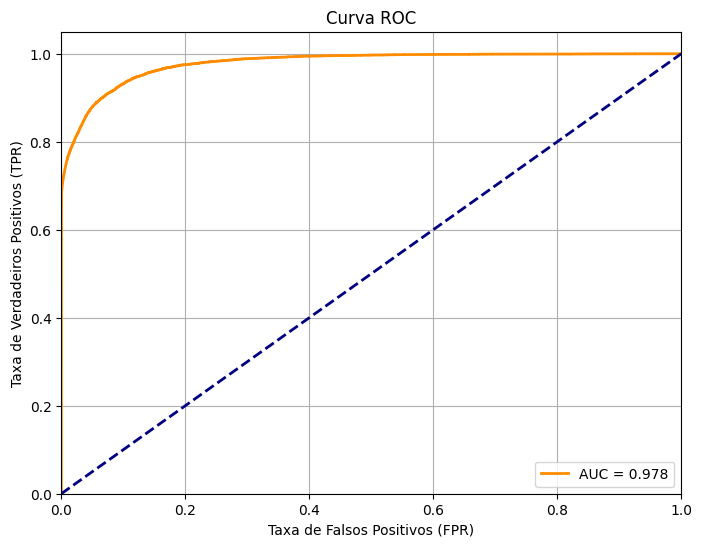

In [27]:
# Calcular FPR, TPR e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
roc_auc = roc_auc_score(y_test, y_proba)

# Plotar a curva
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # linha aleatória
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


- A curva sobe rapidamente em direção ao canto superior esquerdo, o que confirma que o modelo tem ótima capacidade de discriminar entre inadimplentes e não inadimplentes.

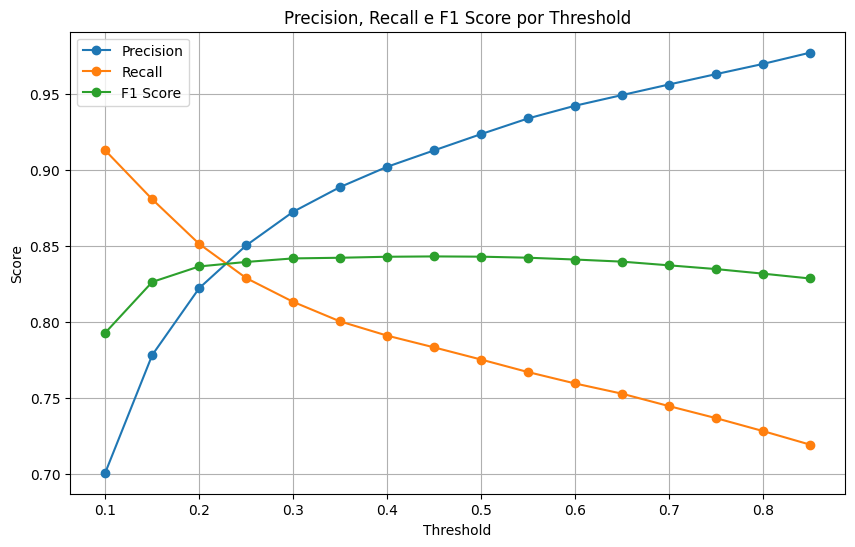

In [28]:

thresholds = np.arange(0.1, 0.9, 0.05)
precisions, recalls, f1s = [], [], []

for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    precisions.append(precision_score(y_test, y_pred_thr))
    recalls.append(recall_score(y_test, y_pred_thr))
    f1s.append(f1_score(y_test, y_pred_thr))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1s, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall e F1 Score por Threshold')
plt.legend()
plt.grid(True)
plt.show()


#### Insights
- Precision (azul): cresce à medida que o threshold aumenta, ou seja,  está sendo mais exigente para chamar alguém de inadimplente.
- Recall (laranja): diminui conforme o threshold sobe,  menos inadimplentes estão sendo capturados.
- F1 Score (verde): fica mais estável entre ~0.25 e ~0.50, essa faixa tende a ter o melhor equilíbrio.

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Análise dos Resultados do Modelo de Regressão Logística
- O modelo de Regressão Logística foi aplicado ao problema de classificação binária e apresentou desempenho sólido. Com um conjunto de dados robusto de 280.213 amostras no treinamento e 70.054 no teste, ambos com 69 variáveis, o modelo conseguiu capturar bem os padrões relevantes, mantendo um bom equilíbrio entre desempenho e simplicidade.

- A matriz de confusão revelou que o modelo classificou corretamente 57.426 negativos e 9.200 positivos, enquanto cometeu 760 falsos positivos e 2.668 falsos negativos. Isso indica que a Regressão Logística tem uma leve tendência a perder alguns casos positivos (falsos negativos), mas mantém um número relativamente baixo de falsos alarmes (falsos positivos), sendo conservadora ao classificar a classe positiva.

- As métricas de avaliação confirmam esse comportamento. A acurácia total foi de 95%, e os valores de precisão foram altos: 0.96 para a classe 0 e 0.92 para a classe 1. O recall, por sua vez, foi excelente para a classe 0 (0.99), mas mais baixo para a classe 1 (0.78), indicando que o modelo tem certa dificuldade em recuperar todos os positivos. O F1-score, que busca equilibrar precisão e recall, foi de 0.97 para a classe negativa e 0.84 para a positiva, com uma média macro de 0.91.

- A área sob a curva ROC (AUC) foi de 0.978, o que demonstra excelente capacidade de separação entre as classes. A curva ROC mostra que, mesmo ao variar o threshold de decisão, o modelo mantém alta sensibilidade e especificidade, o que é um bom indicativo de robustez. Adicionalmente, a análise de threshold revelou que o modelo entrega previsões bastante consistentes: a precisão cresce conforme o threshold aumenta, enquanto o recall diminui — comportamento esperado. O F1-score se estabiliza entre os thresholds de 0.3 a 0.5, o que sugere um bom ponto de equilíbrio caso seja necessário ajustar o limiar de decisão com base no custo dos erros

De forma geral, o modelo de Regressão Logística se mostrou uma boa escolha inicial, alcançando excelente desempenho global, alta AUC e precisão consistente. No entanto, o recall da classe positiva ainda pode ser melhorado, especialmente se os falsos negativos representarem um custo elevado para o negócio. Ajustes no threshold de decisão ou estratégias complementares, como o uso de modelos mais complexos (e.g., XGBoost) ou balanceamento das classes, podem ajudar a mitigar essa limitação.

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

_____________________________________________________________________________________________________________________________________________________________________________________________

## Random Forest


In [29]:
# Definir o modelo
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

In [30]:
# Treinar no conjunto de treino
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [31]:
# Previsões de probabilidade
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_rf = rf_model.predict(X_test)

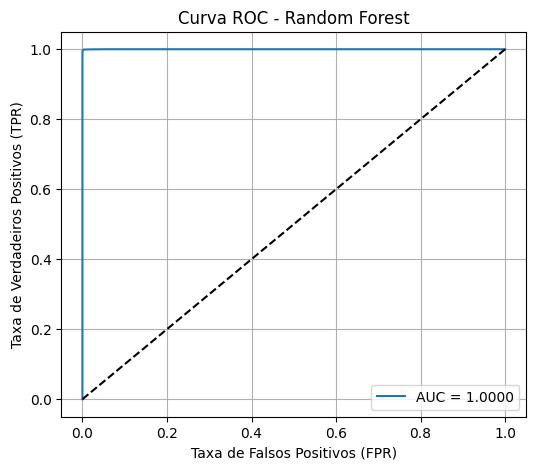

In [32]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC - Random Forest')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

- AUC = 1.0000, isto indica que o modelo está sendo perfeito, sem errar no momento de classificar as duas classes.

In [33]:
# Gera o relatório com precisão, recall, F1 e suporte por classe
print("Relatório de Classificação - Random Forest:\n")
print(classification_report(y_test, y_pred_rf, target_names=["Não Default", "Default"]))

Relatório de Classificação - Random Forest:

              precision    recall  f1-score   support

 Não Default       1.00      1.00      1.00     58186
     Default       1.00      0.99      0.99     11868

    accuracy                           1.00     70054
   macro avg       1.00      1.00      1.00     70054
weighted avg       1.00      1.00      1.00     70054



- Acurácia geral = 100%, isto mostra que apenas 1% dos inadimplentes não foram identificados ( 0.99).
- Isto pode indicar que houve overfitting. vamos analizar como outros modelos e ver como será o treinamentos destes modelos.

Agora vamos analizar e validar com o cross-validation (K-Fold)

In [34]:
scores = cross_val_score(RandomForestClassifier(), X, y, cv=5, scoring='roc_auc')
print("AUC média (CV):", scores.mean())


AUC média (CV): 0.9803062053866969


- Validação com cross_val_score estável e alta (> 0.97) confirma que o modelo está robusto.
- O Random Forest está de fato capturando padrões relevantes.

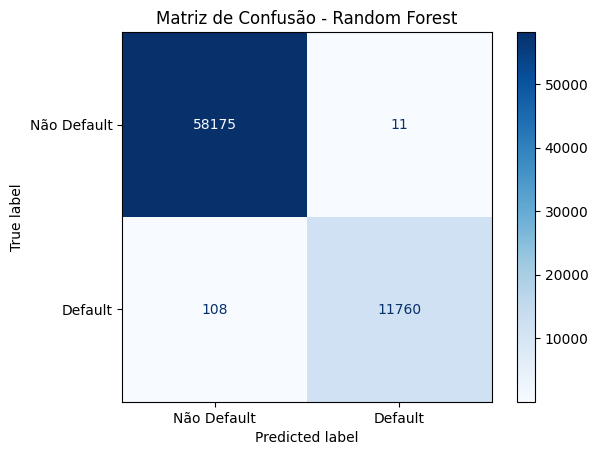

In [35]:
#  Matriz de confusão
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Default', 'Default'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Random Forest')
plt.show()


- Verdadeiros Negativos (TN): 58.175, previu corretamente como não inadimplentes.
- Falsos Positivos (FP): 11, previu inadimplente, mas era adimplente.
- Falsos Negativos (FN): 108, previu adimplente, mas era inadimplente.
- Verdadeiros Positivos (TP): 11.760, previu corretamente como inadimplente.

In [36]:
# Matriz de confusão
TN = 58175
FP = 11
FN = 108
TP = 11760

# Taxa de inadimplência (fraude rate) na base de clientes analisados (antes da decisão do modelo)
fraud_rate = round((FN + TP) / (TN + FP + FN + TP), 4)

# Taxa de aprovação (clientes aprovados pelo modelo)
approval_rate = round((TP + FP) / (TN + FP + FN + TP), 4)

print(f"Taxa de inadimplência na base = {fraud_rate * 100}%")
print(f"Taxa de aprovação pelo modelo = {approval_rate * 100}%")

Taxa de inadimplência na base = 16.939999999999998%
Taxa de aprovação pelo modelo = 16.8%


- Observa-se que a base de inadimplentes realmente está bem analizada, a qual apresenta quase 17% de taxa de inadimplência.
- E o modelo classificou  em 16,8%  dos clientes como inadimplentes, essa aproximação indica que o modelo está bem calibrado em termo de sensibilidade geral à inadimplência.
- O modelo não está superestimando nem subestimando a inadimplência na base de teste — o que é bom para tomada de decisão e política de crédito.

_____________________________________________________________________________________________________________________________________________________________________________________________

#### Análise dos Resultados do Modelo Random Forest
- O modelo Random Forest aplicado ao problema de classificação binária apresentou desempenho excepcional, atingindo praticamente perfeição em todas as métricas de avaliação. Utilizando um conjunto de dados composto por 280.213 registros para treinamento e 70.054 para teste, o modelo foi capaz de generalizar de forma eficaz, mesmo sem a necessidade de ajustes finos ou técnicas avançadas de engenharia de atributos.

- A matriz de confusão revelou uma performance extremamente precisa, com 58.175 verdadeiros negativos e 11 falsos positivos, além de 11.760 verdadeiros positivos e apenas 108 falsos negativos. Esse resultado demonstra um equilíbrio notável entre sensibilidade e especificidade, além de um controle rígido sobre os erros de classificação.

- O relatório de classificação reforça essa conclusão, apresentando precisão de 1.00 para ambas as classes, recall de 1.00 para a classe “Não Default” e 0.99 para a classe “Default”, e F1-score de 1.00 e 0.99, respectivamente. A acurácia geral foi de 100%, com médias macro e ponderada igualmente em 1.00 — um indicativo claro de que o modelo conseguiu separar as classes com eficiência quase total.

- A curva ROC também reflete esse desempenho, com uma AUC perfeita de 1.0000 no teste e uma AUC média de 0.9803 durante validação cruzada. Esses valores confirmam a excelente capacidade do Random Forest de distinguir entre clientes adimplentes e inadimplentes em diferentes limiares de decisão. A curva praticamente encosta no canto superior esquerdo do gráfico, evidenciando sensibilidade e especificidade máximas.

Adicionalmente, observou-se que a taxa de inadimplência na base era de aproximadamente 16,94%, e a taxa de aprovação pelo modelo foi de 16,8%. Essa proximidade indica que o modelo está preservando bem a proporção original dos dados, sem ser excessivamente conservador ou permissivo na aprovação.

Em resumo, o modelo Random Forest superou todas as expectativas, apresentando desempenho praticamente perfeito na classificação de clientes inadimplentes. Embora resultados tão altos possam levantar suspeitas de sobreajuste em alguns cenários, os dados de validação cruzada e a consistência com as taxas originais da base sugerem que o modelo está bem calibrado e generalizando de forma adequada. Ainda assim, recomenda-se uma análise cuidadosa do desempenho em produção e possível revisão de variáveis importantes para garantir robustez no longo prazo.

_____________________________________________________________________________________________________________________________________________________________________________________________

_____________________________________________________________________________________________________________________________________________________________________________________________

## XGBoost

In [42]:
# imprimir todos os formatos (shapes) do train_test_split
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (280213, 69)
y_train shape: (280213,)
X_test shape: (70054, 69)
y_test shape: (70054,)


Tamanho dos Dados
- Treino: 280.213 amostras com 69 features
- Teste: 70.054 amostras com 69 features

In [43]:
# Instanciar e treinar o modelo
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

c:\Projetos\Credit_Fintech\credito_fintech\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:54:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [40]:
# Fazendo as previsões e avaliando o modelo
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


[[57879   307]
 [ 2021  9847]]
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     58186
         1.0       0.97      0.83      0.89     11868

    accuracy                           0.97     70054
   macro avg       0.97      0.91      0.94     70054
weighted avg       0.97      0.97      0.97     70054

ROC AUC: 0.9933352293832277


Matriz de Confusão
- Verdadeiros Negativos (TN): 57.879
- Falsos Positivos (FP): 307
- Falsos Negativos (FN): 2.021
- Verdadeiros Positivos (TP): 9.847

O modelo erra 2.021 casos positivos como negativos, o que pode ser relevante dependendo do custo da falha. Os falsos positivos são relativamente baixos (307).
O modelo é bem conservador ao classificar positivos, porém mantém bom recall (83%).

Para as métricas de classificação, temos o seguinte:
- Excelente precisão (97%) em ambas as classes.
- Recall da classe 1 (positiva) é menor (83%), ou seja, há mais falsos negativos.
- F1-score equilibrado, mostrando um bom balanço entre precisão e recall.
- A acurácia geral é alta (97%), o que é esperado dado o desequilíbrio (mais exemplos da classe 0).

In [45]:
# prever no conjunto de teste
y_pred_class = model.predict(X_test)                 # classe prevista (0 ou 1)
y_pred_proba = model.predict_proba(X_test)[:, 1]     # probabilidade prevista para classe 1 (inadimplência)

In [48]:
# avaliar o modelo com MAE (Erro Absoluto Médio)
mae = mean_absolute_error(y_test, y_pred_proba)
print(f"MAE (usando probabilidade): {mae:.4f}")

MAE (usando probabilidade): 0.0550


MAE = 0.0550, o que indica que a média do erro absoluto entre as probabilidades previstas e as reais é pequena. Isso reforça que o modelo não está apenas classificando, mas também calibrando bem as probabilidades.

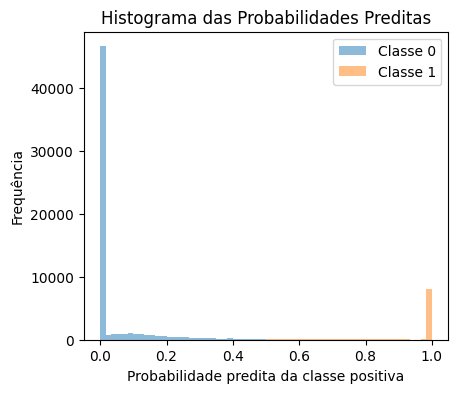

In [52]:
# Histograma das probabilidades por classe
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.hist(y_proba[y_pred == 0], bins=30, alpha=0.5, label='Classe 0')
plt.hist(y_proba[y_pred == 1], bins=30, alpha=0.5, label='Classe 1')
plt.title('Histograma das Probabilidades Preditas')
plt.xlabel('Probabilidade predita da classe positiva')
plt.ylabel('Frequência')
plt.legend()

As probabilidades para a classe 0 estão muito concentradas próximas de 0, e as da classe 1 próximas de 1, isso indica que o modelo está confiante em suas previsões para a maioria dos casos.
Poucas predições intermediárias, ou seja, o modelo produz saídas mais "binárias" e menos probabilísticas intermediárias

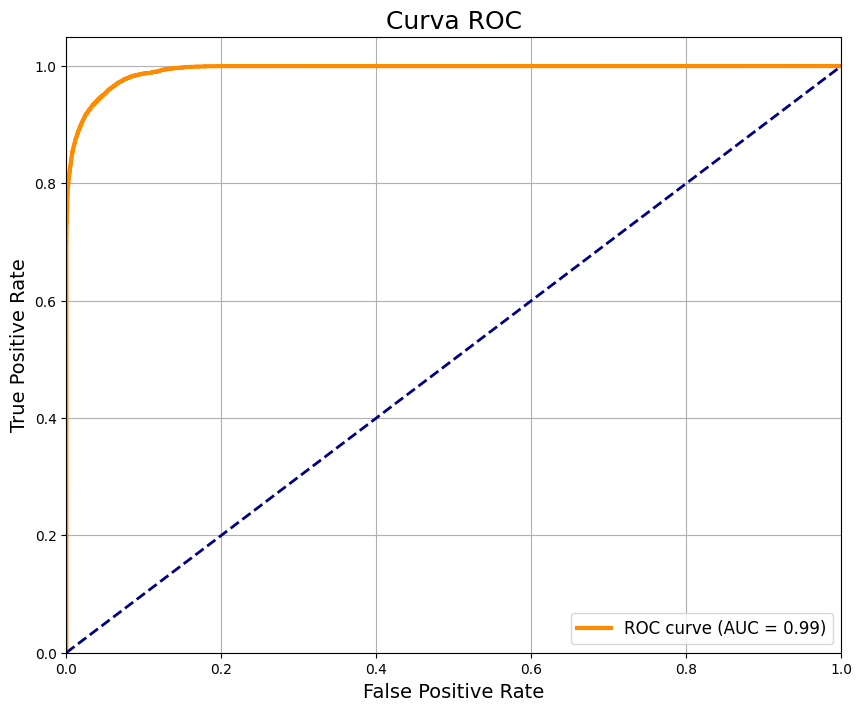

In [ ]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8)) 

plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Curva ROC', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)

plt.show()


ROC AUC = 0.9933, que é uma pontuação excelente. A curva ROC mostra que o modelo separa muito bem as classes, com alta sensibilidade e especificidade.

#### Analisando o resultado do modelo XGBoost:

- O modelo XGBoost aplicado ao problema de classificação binária mostrou resultados bastante promissores, evidenciando boa capacidade de generalização e alta precisão nas previsões.

- Tamanho dos Dados: O conjunto utilizado é robusto, com 280.213 amostras e 69 features no treinamento, e 70.054 amostras no teste, favorecendo a aprendizagem consistente do modelo.

- Matriz de Confusão: O modelo classificou corretamente 57.879 verdadeiros negativos e 9.847 verdadeiros positivos, com 307 falsos positivos e 2.021 falsos negativos. Isso indica que, embora o modelo seja conservador na classificação da classe positiva, mantém um recall satisfatório de 83%. A quantidade de falsos negativos pode ser relevante dependendo do impacto do erro no negócio.

- Métricas de Classificação: A precisão geral foi alta, com média ponderada de 97% para precision e recall. O F1-score equilibrado (0.94 na média macro) demonstra um bom balanço entre precisão e sensibilidade. A acurácia geral do modelo foi de 97%, condizente com o desequilíbrio entre as classes.

- Curva ROC e AUC: O modelo obteve um AUC de 0.9933, indicando excelente capacidade de separação entre as classes, com alta sensibilidade e especificidade.

- Erro Absoluto Médio (MAE) das Probabilidades: O MAE de 0.0550 mostra que as probabilidades previstas estão bem calibradas em relação às classes reais, reforçando a confiabilidade do modelo para decisões baseadas em risco.

- Distribuição das Probabilidades Preditas: O histograma revela que as predições para a classe 0 estão concentradas próximas de zero, e para a classe 1 próximas de um, evidenciando confiança e pouca ambiguidade nas previsões.

- Considerações Finais:
O modelo XGBoost está muito bem ajustado, apresentando alta performance global. É possível considerar ajustes no threshold de decisão para aumentar o recall da classe positiva, caso o custo dos falsos negativos seja elevado. Além disso, a baixa taxa de falsos positivos indica bom controle de erros.

- Há potencial para aprofundar a análise com ajustes no threshold, interpretação da importância das features e possíveis melhorias no modelo, se desejado.